In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
serie_A_data = pd.read_csv('SerieA.csv', delimiter=',')

In [3]:
print(serie_A_data.head())

   yyyy-mm-dd  HH:MM     team1     team2  score1  score2
0  2018-08-18  18:00    Chievo  Juventus       2       3
1  2018-08-18  20:30     Lazio    Napoli       1       2
2  2018-08-19  18:00    Torino      Roma       0       1
3  2018-08-19  20:30  Sassuolo     Inter       1       0
4  2018-08-19  20:30     Parma   Udinese       2       2


In [4]:
def get_posterior(initial_point, num_samples, y, beta_inv, m_s, sigma_s):

    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2]) 
    samples[0] = point
    A = np.array([[1, -1]])
    
    for i in range(num_samples):
        s1_sample, s2_sample = samples[i]
        if y==1:
            t = stats.truncnorm.rvs(a=0, b=np.inf, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))  # p(t|s1, s2, y)
        elif y==-1:
            t = stats.truncnorm.rvs(a=-np.inf, b=0, loc=(s1_sample - s2_sample), scale=np.sqrt(beta_inv))
            
        S = np.linalg.inv(np.linalg.inv(sigma_s) + (beta_inv)**(-1) * (A.T @ A))
        m = S @ (np.linalg.inv(sigma_s) @ m_s + beta_inv**(-1) * A.T * t)

        point = np.random.multivariate_normal(m.ravel(), S)
        samples[i+1] = point

    return m[0][0], m[1][0], S[0,0], S[1,1], point

In [5]:
beta_inv = 1
num_samples = 1000
mu_0 = 25.0
sigma_0 = 40.0

unique_teams = pd.concat([serie_A_data['team1'], serie_A_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    y = 1 if score1 > score2 else -1

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]


Processing Matches: 100%|██████████| 380/380 [02:40<00:00,  2.37match/s]


c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

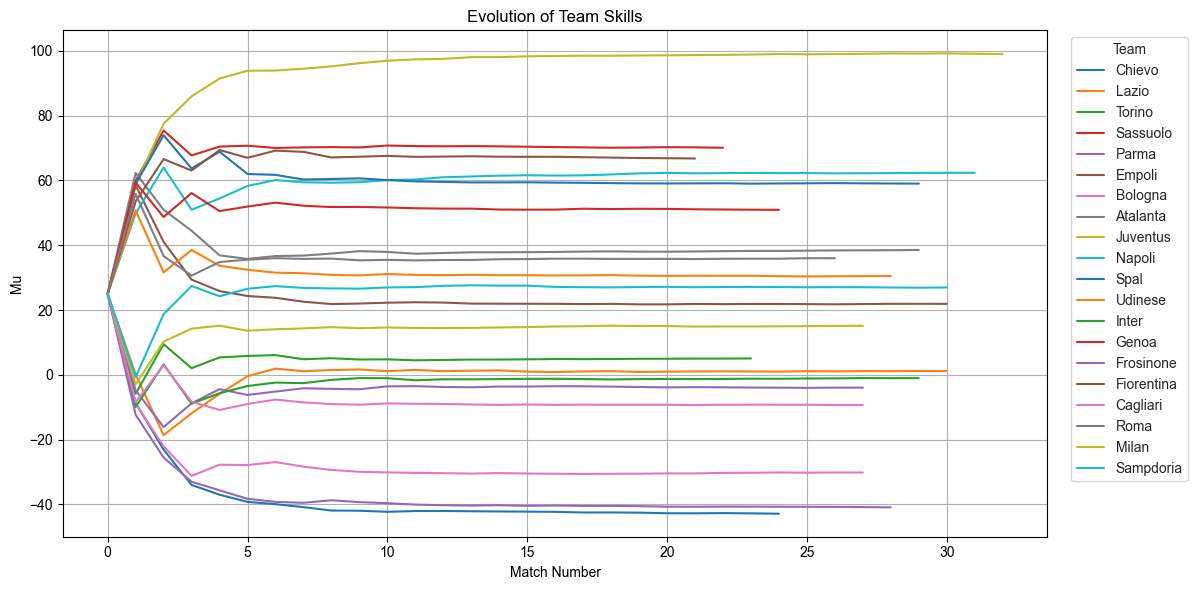

In [6]:

plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of Team Skills")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

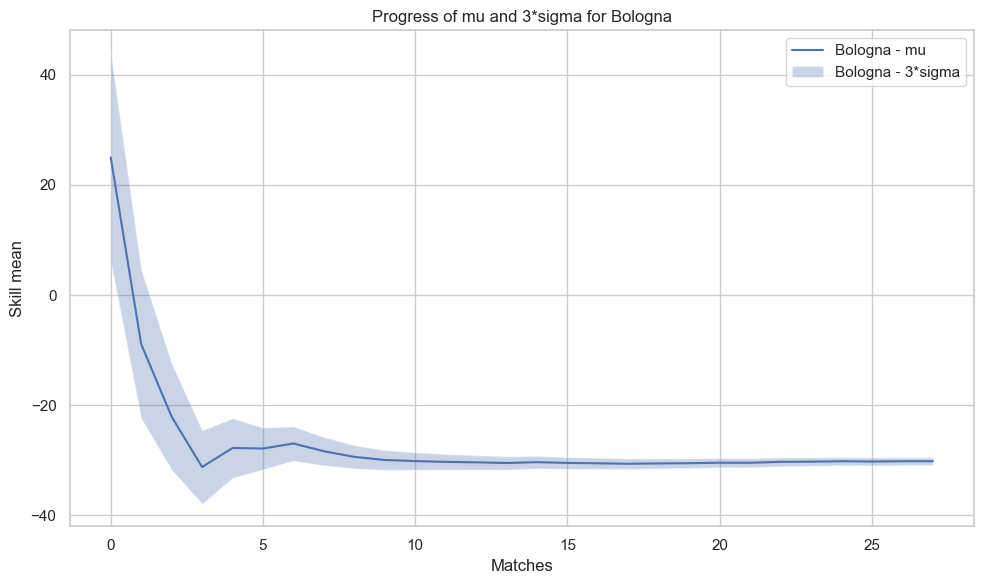

In [7]:

team_name = "Bologna"
team_data = skills_history[team_name]

df = pd.DataFrame(team_data, columns=["mu", "sigma"])
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x=df.index, y="mu", label=f"{team_name} - mu")
alpha = 3
plt.fill_between(
    x=df.index,
    y1=df["mu"] - alpha*np.sqrt(df["sigma"]),
    y2=df["mu"] + alpha*np.sqrt(df["sigma"]),
    alpha=0.3,
    label=f"{team_name} - {alpha}*sigma",
)

plt.xlabel("Matches")
plt.ylabel("Skill mean")
plt.title(f"Progress of mu and 3*sigma for {team_name}")
plt.legend()
plt.tight_layout()
plt.grid(True)

plt.show()

In [8]:
sorted_skills_df = skills_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")

 1 -- Team: Juventus        | mu:   99.02 | sigma:    0.05
 2 -- Team: Sassuolo        | mu:   70.09 | sigma:    0.07
 3 -- Team: Fiorentina      | mu:   66.78 | sigma:    0.07
 4 -- Team: Napoli          | mu:   62.35 | sigma:    0.05
 5 -- Team: Spal            | mu:   59.02 | sigma:    0.05
 6 -- Team: Genoa           | mu:   50.92 | sigma:    0.06
 7 -- Team: Atalanta        | mu:   38.54 | sigma:    0.05
 8 -- Team: Roma            | mu:   35.98 | sigma:    0.05
 9 -- Team: Udinese         | mu:   30.48 | sigma:    0.05
10 -- Team: Sampdoria       | mu:   26.97 | sigma:    0.05
11 -- Team: Empoli          | mu:   21.90 | sigma:    0.05
12 -- Team: Milan           | mu:   15.14 | sigma:    0.05
13 -- Team: Torino          | mu:    5.05 | sigma:    0.06
14 -- Team: Lazio           | mu:    1.15 | sigma:    0.05
15 -- Team: Inter           | mu:   -1.02 | sigma:    0.05
16 -- Team: Parma           | mu:   -3.96 | sigma:    0.06
17 -- Team: Cagliari        | mu:   -9.32 | sigma:    0.

### Shuffle dataframe


In [9]:
serie_A_shuffle = serie_A_data.sample(frac = 1)


In [10]:
beta_inv = 1
num_samples = 1000
mu_0 = 25.0
sigma_0 = 40.0

skills_shuffle_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})
skills_history_shuffle = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(serie_A_shuffle.iterrows(), total=serie_A_shuffle.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    
    mu1 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 's'].values[0]
    s2 = skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 's'].values[0]

    y = 1 if score1 > score2 else -1    
   
    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    skills_history_shuffle[team1].append((mu1_new, sigma1_new))
    skills_history_shuffle[team2].append((mu2_new, sigma2_new))

    skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 'mu'] = mu1_new
    skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 'sigma'] = sigma1_new
    skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 'mu'] = mu2_new
    skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 'sigma'] = sigma2_new
    skills_shuffle_df.loc[skills_shuffle_df['team'] == team1, 's'] = point[0]
    skills_shuffle_df.loc[skills_shuffle_df['team'] == team2, 's'] = point[1]


Processing Matches:   0%|          | 0/380 [00:00<?, ?match/s]

Processing Matches:  22%|██▏       | 85/380 [01:25<04:56,  1.00s/match]


KeyboardInterrupt: 

c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\axele\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

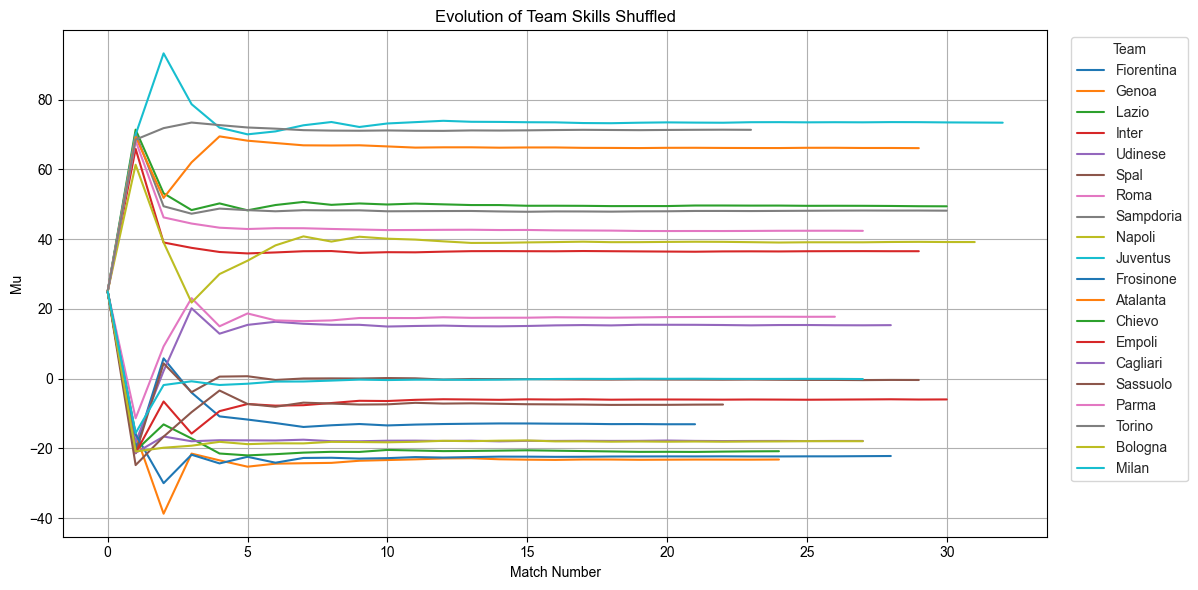

In [ ]:

plt.figure(figsize=(12, 6))
ax = plt.gca()

sns.set_style("whitegrid")

for team, mu_sigma_values in skills_history_shuffle.items():
    mu_values = [mu for mu, sigma in mu_sigma_values]
    x_values = range(len(mu_values))
    sns.lineplot(x=x_values, y=mu_values, ax=ax, label=team)

plt.title("Evolution of Team Skills Shuffled")
plt.xlabel('Match Number')
plt.ylabel('Mu')
plt.legend(title='Team', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sorted_skills_sh_df = skills_shuffle_df.sort_values(by='mu', ascending=False)

for i, (index, row) in enumerate(sorted_skills_sh_df.iterrows()):
    team = row['team']
    mu = row['mu']
    sigma = row['sigma']
    print(f"{i+1:2d} -- Team: {team:<15s} | mu: {mu:>7.2f} | sigma: {sigma:>7.2f}")

 0 -- Team: Juventus        | mu:   73.40 | sigma:    0.02
 1 -- Team: Torino          | mu:   71.36 | sigma:    0.03
 2 -- Team: Atalanta        | mu:   66.11 | sigma:    0.02
 3 -- Team: Lazio           | mu:   49.42 | sigma:    0.03
 4 -- Team: Sampdoria       | mu:   48.17 | sigma:    0.02
 5 -- Team: Parma           | mu:   42.39 | sigma:    0.02
 6 -- Team: Napoli          | mu:   39.18 | sigma:    0.03
 7 -- Team: Inter           | mu:   36.55 | sigma:    0.02
 8 -- Team: Roma            | mu:   17.76 | sigma:    0.03
 9 -- Team: Udinese         | mu:   15.35 | sigma:    0.03
10 -- Team: Milan           | mu:   -0.10 | sigma:    0.02
11 -- Team: Spal            | mu:   -0.38 | sigma:    0.02
12 -- Team: Empoli          | mu:   -5.95 | sigma:    0.02
13 -- Team: Sassuolo        | mu:   -7.42 | sigma:    0.03
14 -- Team: Fiorentina      | mu:  -13.06 | sigma:    0.04
15 -- Team: Cagliari        | mu:  -17.85 | sigma:    0.02
16 -- Team: Bologna         | mu:  -17.93 | sigma:    0.

## Q6

In [9]:
def prediction(mu_s, sigma_s, beta_inv):
    A = np.array([[1, -1]])
    mu_t = A @ mu_s
    sigma_t = beta_inv + A @ sigma_s @ A.T
    p = stats.norm.cdf(0, loc=mu_t, scale=np.sqrt(sigma_t))
    return -1 if p > 0.5 else 1
    

I don't understand wheter this is supposed to take place during the skill-estimation loop.

In [10]:
beta_inv = 1
pred_wins_team1 = []
true_wins_team1 = []
for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    
    pred = prediction(mu_s = np.array([[mu1], [mu2]]),
                        sigma_s = np.array([[sigma1, 0], [0, sigma2]]),
                        beta_inv = beta_inv)
    
    pred_wins_team1.append(pred)
    true_wins_team1.append(1 if score1 > score2 else -1)
r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1) if pred == true)/len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")


Processing Matches:   0%|          | 0/380 [00:00<?, ?match/s]

Processing Matches: 100%|██████████| 380/380 [00:00<00:00, 746.85match/s]

Prediction Rate = 0.607


# Q6 alt.

In [11]:
beta_inv = 1
num_samples = 1000
mu_0 = 25.0
sigma_0 = 40.0

unique_teams = pd.concat([serie_A_data['team1'], serie_A_data['team2']]).unique()
skills_df = pd.DataFrame({'team': unique_teams,
    'mu': [mu_0] * len(unique_teams),
    'sigma': [sigma_0] * len(unique_teams),
    's' : np.random.normal(mu_0, sigma_0)
})
skills_history = {team: [(mu_0, sigma_0)] for team in list(unique_teams)}

for _, match_instance in tqdm(serie_A_data.iterrows(), total=serie_A_data.shape[0], desc="Processing Matches", leave=True, position=0, unit='match'):
    team1, team2, score1, score2 = match_instance['team1'], match_instance['team2'], match_instance['score1'], match_instance['score2']
    if score1 == score2:
        continue
    
    mu1 = skills_df.loc[skills_df['team'] == team1, 'mu'].values[0]
    sigma1 = skills_df.loc[skills_df['team'] == team1, 'sigma'].values[0]
    mu2 = skills_df.loc[skills_df['team'] == team2, 'mu'].values[0]
    sigma2 = skills_df.loc[skills_df['team'] == team2, 'sigma'].values[0]
    s1 = skills_df.loc[skills_df['team'] == team1, 's'].values[0]
    s2 = skills_df.loc[skills_df['team'] == team2, 's'].values[0]

    y = 1 if score1 > score2 else -1

    y_pred = prediction(mu_s = np.array([[mu1], [mu2]]),
                        sigma_s = np.array([[sigma1, 0], [0, sigma2]]),
                        beta_inv = beta_inv)
    
    pred_wins_team1.append(y_pred)
    true_wins_team1.append(y)

    mu1_new, mu2_new, sigma1_new, sigma2_new, point = get_posterior(initial_point = [s1, s2],
                                                            num_samples = num_samples,
                                                            y = y,
                                                            beta_inv = beta_inv,
                                                            m_s = np.array([[mu1], [mu2]]),
                                                            sigma_s = np.array([[sigma1, 0], [0, sigma2]]))
    
    skills_history[team1].append((mu1_new, sigma1_new))
    skills_history[team2].append((mu2_new, sigma2_new))

    skills_df.loc[skills_df['team'] == team1, 'mu'] = mu1_new
    skills_df.loc[skills_df['team'] == team1, 'sigma'] = sigma1_new
    skills_df.loc[skills_df['team'] == team2, 'mu'] = mu2_new
    skills_df.loc[skills_df['team'] == team2, 'sigma'] = sigma2_new
    skills_df.loc[skills_df['team'] == team1, 's'] = point[0]
    skills_df.loc[skills_df['team'] == team2, 's'] = point[1]

r = sum(1 for pred, true in zip(pred_wins_team1, true_wins_team1) if pred == true)/len(true_wins_team1)
print(f"Prediction Rate = {round(r, 3)}")


Processing Matches: 100%|██████████| 380/380 [02:32<00:00,  2.50match/s]

Prediction Rate = 0.594
